In [1]:
"""
Example workflow demonstrating how to use the improved GraphBuilder
for planar graph classification with 11-14 nodes
"""

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool,global_add_pool, GraphNorm
from torch_geometric.data import Data, DataLoader
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import pandas as pd
import ast

In [ ]:


class GINNet(nn.Module):
    """
    Graph Isomorphism Network - More powerful than GCN for graph-level tasks
    GIN is provably as powerful as the WL test for graph isomorphism
    """
    def __init__(self, num_features, hidden_dim=64, num_classes=2, dropout=0.2, num_layers=3):
        super(GINNet, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Build GIN layers
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
                mlp = nn.Sequential(
                    nn.Linear(num_features, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim)
                )
            else:
                mlp = nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim)
                )
            
            conv = GINConv(mlp)
            self.convs.append(conv)
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # Jumping knowledge - combine features from all layers
        self.jump = nn.Linear(num_layers * hidden_dim, hidden_dim)
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x, edge_index, batch=None):
        # Store representations from each layer
        layer_representations = []
        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            
            # Store layer representation
            layer_representations.append(x)
        
        # Jumping knowledge connection
        x = torch.cat(layer_representations, dim=-1)
        x = self.jump(x)
        
        # Global pooling
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        x = global_add_pool(x, batch)
        
        # Classification
        return self.classifier(x)

In [3]:
def create_graph_dataset(graphs_data: List[Tuple[List, int]], 
                        feature_config: Dict) -> List[Data]:
    """
    Create dataset from graph data using improved GraphBuilder
    
    Args:
        graphs_data: List of (edges, label) tuples
        feature_config: Configuration for GraphBuilder
        
    Returns:
        List of PyTorch Geometric Data objects
    """
    from GraphBuilder_with_features_Claude import GraphBuilder
    
    dataset = []
    all_features = []
    
    # First pass: collect all features for normalization
    print("Extracting features...")
    for edges, label in graphs_data:
        builder = GraphBuilder(
            solid_edges=edges,
            coeff=label,
            **feature_config
        )
        data = builder.build()
        dataset.append(data)
        all_features.append(data.x.numpy())
    
    # Compute normalization statistics
    all_features = np.vstack(all_features)
    scaler = StandardScaler()
    scaler.fit(all_features)
    
    # Second pass: normalize features
    print("Normalizing features...")
    for i, data in enumerate(dataset):
        # Get the starting index for this graph's features
        start_idx = sum(d.num_nodes for d in dataset[:i])
        end_idx = start_idx + data.num_nodes
        
        # Normalize
        normalized_features = scaler.transform(data.x.numpy())
        data.x = torch.FloatTensor(normalized_features)
    
    print(f"Created dataset with {len(dataset)} graphs")
    print(f"Feature dimensions: {dataset[0].x.shape[1]}")
    print(f"Feature names: {dataset[0].feature_names}")
    
    return dataset, scaler


def evaluate_feature_importance(model, dataset, feature_names):
    """Evaluate which features are most important for the model"""
    
    model.eval()
    feature_gradients = []
    
    with torch.enable_grad():
        for data in dataset:
            data.x.requires_grad = True
            
            # Forward pass
            out = model(data.x, data.edge_index)
            loss = F.nll_loss(out, data.y.unsqueeze(0))
            
            # Backward pass
            loss.backward()
            
            # Store gradients
            grad = data.x.grad.abs().mean(dim=0)
            feature_gradients.append(grad.numpy())
    
    # Average gradients across all graphs
    avg_gradients = np.mean(feature_gradients, axis=0)
    
    # Sort features by importance
    importance_scores = list(zip(feature_names, avg_gradients))
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    
    return importance_scores

def train_and_evaluate(dataset, feature_config, num_epochs=100, k_folds=5):
    """Train and evaluate model using k-fold cross validation with learning rate scheduling"""
    
    # Prepare for k-fold cross validation
    labels = [data.y.item() for data in dataset]
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_feature_importance = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(range(len(dataset)), labels)):
        print(f"\nFold {fold + 1}/{k_folds}")
        
        # Split dataset
        train_dataset = [dataset[i] for i in train_idx]
        test_dataset = [dataset[i] for i in test_idx]
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Initialize model
        num_features = dataset[0].x.shape[1]
        model = PlanarGraphGNN(num_features, hidden_dim=32, num_classes=2)
        
        # Initialize optimizer with a higher initial learning rate
        # The scheduler will handle the reduction
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
        
        # Learning rate scheduler
        # ReduceLROnPlateau: Reduces LR when validation loss plateaus
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    optimizer, 
        #    mode='min',  # Minimize loss
        #    factor=0.5,  # Reduce LR by half
        #    patience=10,  # Wait 10 epochs before reducing
        #    min_lr=1e-5,  # Minimum LR
        #)
        
        # Alternative schedulers you could use:
        # 1. CosineAnnealingLR - smooth cosine decay
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        #     optimizer, T_max=num_epochs, eta_min=1e-5
        # )
        
        # 2. StepLR - step decay at fixed intervals
        # scheduler = torch.optim.lr_scheduler.StepLR(
        #     optimizer, step_size=30, gamma=0.5
        # )
        
        # 3. OneCycleLR - one cycle policy (very effective for small datasets)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=0.1, epochs=num_epochs, 
            steps_per_epoch=len(train_loader)
        )
        
        # Training
        best_val_loss = float('inf')
        patience_counter = 0
        early_stop_patience = 20
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = F.nll_loss(out, batch.y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # Validation phase
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                # Use train dataset as validation since we have limited data
                for batch in train_loader:
                    out = model(batch.x, batch.edge_index, batch.batch)
                    val_loss += F.nll_loss(out, batch.y).item()
                    pred = out.argmax(dim=1)
                    correct += pred.eq(batch.y).sum().item()
                    total += batch.y.size(0)
            
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(train_loader)
            val_acc = correct / total
            
            # Update learning rate based on validation loss
            scheduler.step(avg_val_loss)
            
            # For OneCycleLR, call scheduler.step() after each batch instead
            if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()
            
            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print(f"  Early stopping at epoch {epoch + 1}")
                    break
            
            if (epoch + 1) % 20 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
                      f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")
        
        # Final evaluation on test set
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                out = model(batch.x, batch.edge_index, batch.batch)
                pred = out.argmax(dim=1)
                correct += pred.eq(batch.y).sum().item()
                total += batch.y.size(0)
        
        accuracy = correct / total
        fold_accuracies.append(accuracy)
        print(f"  Test Accuracy: {accuracy:.4f}")
        
        # Feature importance for this fold
        if hasattr(dataset[0], 'feature_names'):
            importance = evaluate_feature_importance(model, test_dataset, 
                                                   dataset[0].feature_names)
            fold_feature_importance.append(importance)
    
    # Summary
    print(f"\n{'='*50}")
    print(f"Cross-validation Results:")
    print(f"  Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
    print(f"  All Folds: {fold_accuracies}")
    
    # Average feature importance across folds
    if fold_feature_importance:
        avg_importance = {}
        for feat_name in dataset[0].feature_names:
            scores = [dict(fold)[feat_name] for fold in fold_feature_importance]
            avg_importance[feat_name] = np.mean(scores)
        
        print(f"\nTop 10 Most Important Features:")
        sorted_importance = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
        for i, (feat, score) in enumerate(sorted_importance[:10]):
            print(f"  {i+1}. {feat:25s}: {score:.4f}")
    
    return fold_accuracies, avg_importance



In [6]:

def compare_feature_sets(graphs_data):
    """Compare different feature configurations"""
    
    feature_configs = {
        'Minimal': {
            'selected_features': ['basic', 'face'],
            'laplacian_pe_k': 0
        },
        'Planar-focused': {
            'selected_features': ['basic', 'face', 'dual'],
            'laplacian_pe_k': 2
        },
        'Balanced': {
            'selected_features': ['basic', 'face', 'spectral_node', 'centrality'],
            'laplacian_pe_k': 3
        },
        'Full': {
            'selected_features': ['basic', 'face', 'spectral_node', 'dual', 'centrality'],
            'laplacian_pe_k': 4
        }
    }
    
    results = {}
    
    for config_name, config in feature_configs.items():
        print(f"\n{'='*60}")
        print(f"Testing configuration: {config_name}")
        print(f"{'='*60}")
        
        # Create dataset with this configuration
        dataset, scaler = create_graph_dataset(graphs_data, config)
        
        # Train and evaluate
        accuracies, importance = train_and_evaluate(dataset, config, num_epochs=50)
        
        results[config_name] = {
            'accuracies': accuracies,
            'mean_accuracy': np.mean(accuracies),
            'std_accuracy': np.std(accuracies),
            'num_features': dataset[0].x.shape[1],
            'importance': importance
        }
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    
    configs = list(results.keys())
    means = [results[c]['mean_accuracy'] for c in configs]
    stds = [results[c]['std_accuracy'] for c in configs]
    num_features = [results[c]['num_features'] for c in configs]
    
    x = np.arange(len(configs))
    
    plt.subplot(1, 2, 1)
    plt.bar(x, means, yerr=stds, capsize=10)
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy')
    plt.title('Model Performance by Feature Configuration')
    plt.xticks(x, configs, rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.scatter(num_features, means, s=100)
    plt.errorbar(num_features, means, yerr=stds, fmt='none', capsize=5)
    for i, config in enumerate(configs):
        plt.annotate(config, (num_features[i], means[i]), 
                    xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Feature Dimensionality')
    
    plt.tight_layout()
    plt.show()
    
    return results



In [ ]:
# Generate dataset
#print("Generating example planar graphs...")
#graphs_data = generate_example_graphs(100)

Generating example planar graphs...


In [4]:
loop=8
# Create the edge and y lists from the csv files\
edges=[]
y=[]
for i in range(loop,loop+1):
    filename = f'../Graph_Edge_Data/den_graph_data_{loop}.csv'
    df = pd.read_csv(filename)
    edges += df['EDGES'].tolist()
    y += df['COEFFICIENTS'].tolist()
edges = [ast.literal_eval(e) for e in edges]    
graphs_data = list(zip(edges, y))


Testing configuration: Minimal
Extracting features...
Normalizing features...
Created dataset with 1432 graphs
Feature dimensions: 5
Feature names: ['degree', 'num_faces', 'avg_face_size', 'max_face_size', 'face_size_variance']

Fold 1/5


/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/50, Train Loss: 0.5844, Val Loss: 0.5713, Val Acc: 0.6952, LR: 0.004002
  Epoch 40/50, Train Loss: 0.5540, Val Loss: 0.5437, Val Acc: 0.7214, LR: 0.004002
  Test Accuracy: 0.7178

Fold 2/5
  Epoch 20/50, Train Loss: 0.5670, Val Loss: 0.5566, Val Acc: 0.7188, LR: 0.004002
  Epoch 40/50, Train Loss: 0.5488, Val Loss: 0.5372, Val Acc: 0.7266, LR: 0.004002
  Test Accuracy: 0.7003

Fold 3/5
  Epoch 20/50, Train Loss: 0.5570, Val Loss: 0.5392, Val Acc: 0.7155, LR: 0.004002
  Epoch 40/50, Train Loss: 0.5454, Val Loss: 0.5273, Val Acc: 0.7260, LR: 0.004002
  Test Accuracy: 0.6853

Fold 4/5
  Epoch 20/50, Train Loss: 0.5592, Val Loss: 0.5516, Val Acc: 0.7208, LR: 0.004002
  Epoch 40/50, Train Loss: 0.5472, Val Loss: 0.5325, Val Acc: 0.7269, LR: 0.004002
  Test Accuracy: 0.6608

Fold 5/5
  Epoch 20/50, Train Loss: 0.5601, Val Loss: 0.5655, Val Acc: 0.7147, LR: 0.004002
  Epoch 40/50, Train Loss: 0.5594, Val Loss: 0.5279, Val Acc: 0.7182, LR: 0.004002
  Test Accuracy: 0.6818

Cross-val

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/50, Train Loss: 0.5483, Val Loss: 0.5201, Val Acc: 0.7074, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4976, Val Loss: 0.4701, Val Acc: 0.7642, LR: 0.004002
  Test Accuracy: 0.7735

Fold 2/5
  Epoch 20/50, Train Loss: 0.5183, Val Loss: 0.5042, Val Acc: 0.7528, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4915, Val Loss: 0.4639, Val Acc: 0.7598, LR: 0.004002
  Test Accuracy: 0.7317

Fold 3/5
  Epoch 20/50, Train Loss: 0.5322, Val Loss: 0.5183, Val Acc: 0.7155, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4921, Val Loss: 0.4718, Val Acc: 0.7426, LR: 0.004002
  Test Accuracy: 0.7028

Fold 4/5
  Epoch 20/50, Train Loss: 0.5160, Val Loss: 0.4948, Val Acc: 0.7373, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4615, Val Loss: 0.4466, Val Acc: 0.7696, LR: 0.004002
  Test Accuracy: 0.6923

Fold 5/5
  Epoch 20/50, Train Loss: 0.5318, Val Loss: 0.4997, Val Acc: 0.7312, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4767, Val Loss: 0.4666, Val Acc: 0.7618, LR: 0.004002
  Test Accuracy: 0.7692

Cross-val

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/50, Train Loss: 0.4424, Val Loss: 0.4171, Val Acc: 0.8035, LR: 0.004002
  Epoch 40/50, Train Loss: 0.3973, Val Loss: 0.3663, Val Acc: 0.8332, LR: 0.004002
  Test Accuracy: 0.7909

Fold 2/5
  Epoch 20/50, Train Loss: 0.4480, Val Loss: 0.4241, Val Acc: 0.8044, LR: 0.004002
  Epoch 40/50, Train Loss: 0.3936, Val Loss: 0.3781, Val Acc: 0.8192, LR: 0.004002
  Test Accuracy: 0.7561

Fold 3/5
  Epoch 20/50, Train Loss: 0.4708, Val Loss: 0.4458, Val Acc: 0.7827, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4370, Val Loss: 0.4265, Val Acc: 0.7888, LR: 0.004002
  Test Accuracy: 0.7517

Fold 4/5
  Epoch 20/50, Train Loss: 0.4741, Val Loss: 0.4468, Val Acc: 0.7862, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4289, Val Loss: 0.4150, Val Acc: 0.7993, LR: 0.004002
  Test Accuracy: 0.7657

Fold 5/5
  Epoch 20/50, Train Loss: 0.4740, Val Loss: 0.4568, Val Acc: 0.7784, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4472, Val Loss: 0.4398, Val Acc: 0.7766, LR: 0.004002
  Test Accuracy: 0.8077

Cross-val

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/50, Train Loss: 0.4589, Val Loss: 0.4141, Val Acc: 0.8061, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4179, Val Loss: 0.4313, Val Acc: 0.7799, LR: 0.004002
  Test Accuracy: 0.7875

Fold 2/5
  Epoch 20/50, Train Loss: 0.4506, Val Loss: 0.4370, Val Acc: 0.7983, LR: 0.004002
  Epoch 40/50, Train Loss: 0.3905, Val Loss: 0.3734, Val Acc: 0.8183, LR: 0.004002
  Test Accuracy: 0.7840

Fold 3/5
  Epoch 20/50, Train Loss: 0.4841, Val Loss: 0.5076, Val Acc: 0.7487, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4318, Val Loss: 0.3740, Val Acc: 0.8202, LR: 0.004002
  Test Accuracy: 0.8007

Fold 4/5
  Epoch 20/50, Train Loss: 0.4722, Val Loss: 0.4344, Val Acc: 0.7862, LR: 0.004002
  Epoch 40/50, Train Loss: 0.3967, Val Loss: 0.3625, Val Acc: 0.8360, LR: 0.004002
  Test Accuracy: 0.7937

Fold 5/5
  Epoch 20/50, Train Loss: 0.4708, Val Loss: 0.4846, Val Acc: 0.7504, LR: 0.004002
  Epoch 40/50, Train Loss: 0.4037, Val Loss: 0.3946, Val Acc: 0.8019, LR: 0.004002
  Test Accuracy: 0.7762

Cross-val

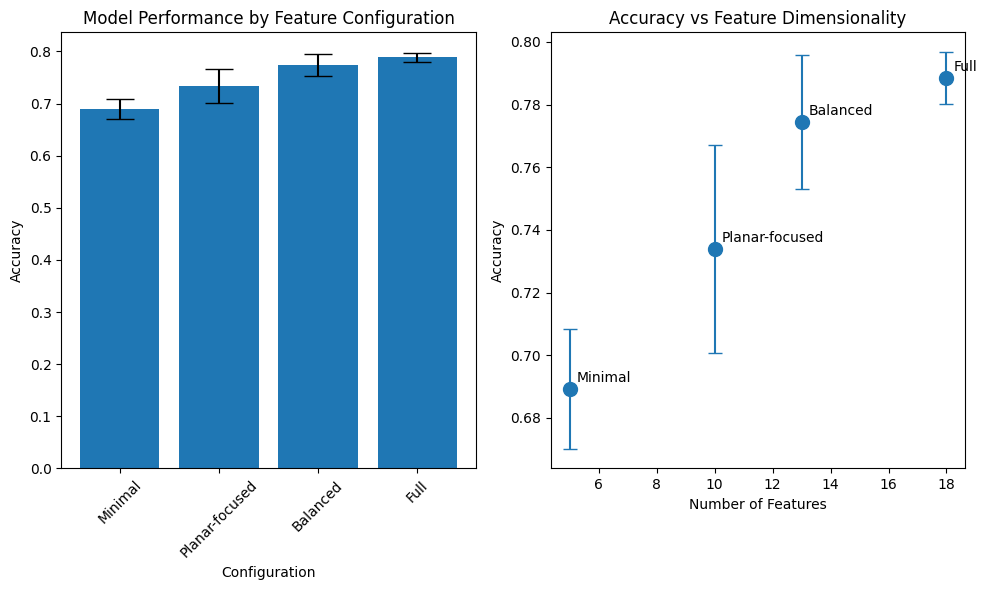

In [7]:
# Compare different feature configurations
results = compare_feature_sets(graphs_data)

In [12]:
# Print summary
print("\n" + "="*60)
print("SUMMARY: Feature Configuration Comparison")
print("="*60)

for config, res in results.items():
    print(f"\n{config}:")
    print(f"  Features: {res['num_features']}")
    print(f"  Accuracy: {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")


SUMMARY: Feature Configuration Comparison

Minimal:
  Features: 5
  Accuracy: 0.6627 ± 0.0105

Planar-focused:
  Features: 10
  Accuracy: 0.7081 ± 0.0319

Balanced:
  Features: 13
  Accuracy: 0.7388 ± 0.0286

Full:
  Features: 18
  Accuracy: 0.7681 ± 0.0143


In [24]:
# Print summary
print("\n" + "="*60)
print("SUMMARY: Feature Configuration Comparison")
print("="*60)

for config, res in results.items():
    print(f"\n{config}:")
    print(f"  Features: {res['num_features']}")
    print(f"  Accuracy: {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")


SUMMARY: Feature Configuration Comparison

Minimal:
  Features: 5
  Accuracy: 0.6836 ± 0.0247

Planar-focused:
  Features: 10
  Accuracy: 0.7479 ± 0.0072

Balanced:
  Features: 13
  Accuracy: 0.7814 ± 0.0115

Full:
  Features: 18
  Accuracy: 0.7758 ± 0.0198


In [27]:
# Print summary
print("\n" + "="*60)
print("SUMMARY: Feature Configuration Comparison")
print("="*60)

for config, res in results.items():
    print(f"\n{config}:")
    print(f"  Features: {res['num_features']}")
    print(f"  Accuracy: {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")


SUMMARY: Feature Configuration Comparison

Minimal:
  Features: 5
  Accuracy: 0.6830 ± 0.0213

Planar-focused:
  Features: 10
  Accuracy: 0.7172 ± 0.0199

Balanced:
  Features: 13
  Accuracy: 0.7619 ± 0.0098

Full:
  Features: 18
  Accuracy: 0.7640 ± 0.0114
